## Impact of top-side TEC on SAR range delay

Dataset: Chile Sen asc track 149

+ Figure. Time-series of GIM/SUB/TOP_TEC and its predicted range delay for X/C/S/L-band SAR

In [34]:
%matplotlib inline
import os
import h5py
from pprint import pprint
import numpy as np
import datetime as dt
import numpy.polynomial.polynomial as poly
from matplotlib import pyplot as plt, ticker, dates as mdates, colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable

from mintpy.objects import timeseries
from mintpy.utils import ptime, readfile, utils as ut, plot as pp
from mintpy.simulation import iono
plt.rcParams.update({'font.size': 12})
speed_of_light = 299792458 # speed of light in m / s

# dir
proj_dir = os.path.expanduser('~/data/geolocation/ChileSenAT149')
proj_name = os.path.basename(proj_dir)

work_dir = os.path.join(proj_dir, 'offset_comp/BoxLR')
os.chdir(work_dir)
print('Go to directory', work_dir)

Go to directory /Users/yunjunz/data/geolocation/ChileSenAT149/offset_comp/BoxLR


## Figure - Topside Ionospheric Impact on SAR

### 1. Read data

In [35]:
geom_file = os.path.join(proj_dir, 'mintpy_offset/inputs/geometryRadar.h5')
tec_file  = os.path.join(proj_dir, 'mintpy_offset/inputs/TECsub.h5')

# geometry
inc_angle = 42   # use the median value of NISAR
inc_angle_iono = iono.incidence_angle_ground2iono(inc_angle)

# TEC
tec_dict = {}
with h5py.File(tec_file, 'r') as f:
    dnames = [x for x in f.keys() if x.startswith('tec_')]
    for dname in dnames:
        tec_dict[dname] = f[dname][:]

# time
date_list = timeseries(tec_file).get_date_list()
dates = ptime.date_list2vector(date_list)[0]

# stats
for key, value in tec_dict.items():
    print('{:<11} min/max/span: {:4.1f} / {:4.1f} / {:4.1f} TECU'.format(key, np.nanmin(value), np.nanmax(value), np.nanmax(value)-np.nanmin(value)))

tec_ipp     min/max/span:  6.6 / 59.1 / 52.5 TECU
tec_sub_ipp min/max/span:  0.6 / 49.2 / 48.6 TECU
tec_sub_tpp min/max/span:  0.6 / 53.3 / 52.7 TECU
tec_top_tpp min/max/span:  2.9 / 11.5 /  8.6 TECU


### 2. Plot

number of tec_top_tpp observations: 93
min  / max: 3 / 11 TECU
mean / std: 6.6 / 1.8 TECU
L  mean / std:   1.7 m  /  0.462 m  ->   0.07 pixel for 24 MHz
L  mean / std:   1.7 m  /  0.462 m  ->   0.14 pixel for 44 MHz
L  mean / std:   1.7 m  /  0.462 m  ->   0.25 pixel for 80 MHz
S  mean / std:  30.6 cm /  7.825 cm ->  0.039 pixel for 75.00 MHz
C  mean / std:  11.5 cm /  3.033 cm ->  0.013 pixel for 64.35 MHz
X  mean / std:   3.8 cm /  1.020 cm ->  0.007 pixel for 109.89 MHz
Ka mean / std:   2.8 mm /  0.773 mm ->  0.001 pixel for 200.00 MHz
save figure to file /Users/yunjunz/data/geolocation/ChileSenAT149/offset_comp/topTEC_pred.pdf


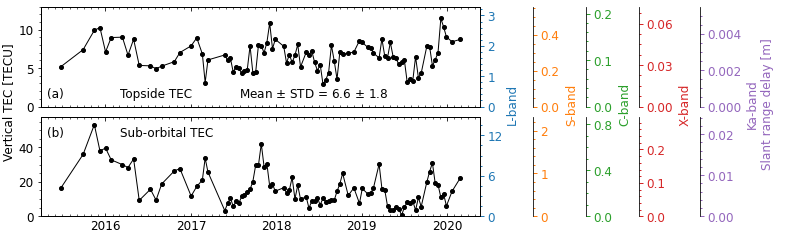

In [36]:
ysteps_dict = {
    'tec_top_tpp' : [1, 0.2, 0.1, 0.03, 0.002],
    'tec_sub_tpp' : [6, 1.0, 0.4, 0.10, 0.01],
}
rg_bw_dict = {
    'S' : 75e6,     #NISAR-S
    'C' : 64.35e6,  #Sentinel-1
    'X' : 109.89e6, #TSX
    'Ka': 200e6,    #SWOT
}
unit_dict = {'L':'m', 'S':'cm', 'C':'cm', 'X':'cm', 'Ka':'mm'}
ylabels = [f'{x}-band' for x in iono.SAR_BAND.keys()]
ylabels[-1] += '\nSlant range delay [m]'
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[12, 3.5], sharex=True)
for i, (ax, tec_type, ymax, ystep) in enumerate(zip(axs, ysteps_dict.keys(), [13, 58], [1, 5])):
    ts_tec = tec_dict[tec_type]
    # omit nan values
    flag = ~np.isnan(ts_tec)
    ts_tec = np.array(ts_tec)[flag]
    x = np.array(dates)[flag]
    if tec_type == 'tec_top_tpp':
        print('number of {} observations: {}'.format(tec_type, np.sum(flag)))
        print('min  / max: {:.0f} / {:.0f} TECU'.format(np.nanmin(ts_tec), np.nanmax(ts_tec)))
        print('mean / std: {:.1f} / {:.1f} TECU'.format(np.nanmean(ts_tec), np.nanstd(ts_tec)))        

    # plot
    ax.plot(x, ts_tec, '-o', label=tec_type, color='k', ms=4, lw=1)
    ax.tick_params(which='both', axis='x', direction='in', top=True, bottom=True)
    ax.set_ylim(0, ymax)
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(ystep))

    # predicted range delay
    ysteps = ysteps_dict[tec_type]
    yaxis_locs = [1.0, 1.12, 1.24, 1.36, 1.50]
    for j, (bname, c, yaxis_loc) in enumerate(zip(iono.SAR_BAND.keys(), colors, yaxis_locs)):
        # calculate
        ts_delay = iono.vtec2range_delay(ts_tec, inc_angle=42, freq=iono.SAR_BAND[bname])
        if tec_type == 'tec_top_tpp':
            # mis-registration in meter
            dmean, dstd = np.nanmean(ts_delay), np.nanstd(ts_delay)
            dunit = unit_dict[bname]
            scale = 1 if dunit == 'm' else (100 if dunit == 'cm' else 1000)
            msg = f'{bname:2s} mean / std: {dmean*scale:5.1f} {dunit:2s} / {dstd*scale:6.3f} {dunit:2s}'
            # mis-registration in pixel
            if bname == 'L':
                for rg_bw in [24e6, 44e6, 80e6]:
                    rg_delay_pix = dstd / (speed_of_light / rg_bw / 2)
                    print(f'{msg} -> {rg_delay_pix:6.2f} pixel for {rg_bw/1e6:.0f} MHz')
            else:
                rg_delay_pix = dstd / (speed_of_light / rg_bw_dict[bname] / 2)
                print(f'{msg} -> {rg_delay_pix:6.3f} pixel for {rg_bw_dict[bname]/1e6:.2f} MHz')

        # add y-axis
        ax2 = ax.twinx()
        ax2.spines['right'].set_position(('axes', yaxis_loc))
        ax2.tick_params(which='both', axis='y', colors=c, width=1)
        ax2.yaxis.set_major_locator(ticker.MultipleLocator(ysteps[j]))
        ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

        # ylim sync btw. ax and ax2
        ratio = ((np.max(ts_delay) - np.min(ts_delay)) / (np.max(ts_tec)   - np.min(ts_tec)))
        ax2.set_ylim(np.array(ax.get_ylim()) * ratio)
        #ax2.plot(x, ts_delay, 'o', mfc='none')  # test

# axis format
pp.auto_adjust_xaxis_date(ax, dates, every_year=1, buffer_year=None)
fig.tight_layout()
fig.subplots_adjust(hspace=0.1)

# label
top_tec_mean = np.nanmean(tec_dict['tec_top_tpp'])
top_tec_std = np.nanstd(tec_dict['tec_top_tpp'])
for ax, num, label, yloc in zip(axs, ['(a)', '(b)'], ['Topside TEC', 'Sub-orbital TEC'], [0.09, 0.8]):
    ax.annotate(num,   xy=(0.015, yloc), xycoords='axes fraction', ha='left')
    ax.annotate(label, xy=(0.180, yloc), xycoords='axes fraction', ha='left', color='k')
axs[0].annotate(r'Mean $\pm$ STD = {:.1f} $\pm$ {:.1f}'.format(top_tec_mean, top_tec_std), xy=(0.45, 0.09), xycoords='axes fraction', ha='left')
plt.annotate('Vertical TEC [TECU]', xy=(0.002, 0.55), xycoords='figure fraction', va='center', rotation='vertical')
for ylabel, color, xloc in zip(ylabels, colors, [0.593, 0.662, 0.723, 0.793, 0.88]):
    plt.annotate(ylabel, xy=(xloc, 0.54), color=color, xycoords='figure fraction', ha='center', va='center', rotation='vertical')

# output
out_fig = os.path.join(proj_dir, 'offset_comp/topTEC_pred.pdf')
print('save figure to file', out_fig)
#plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

## Figure - Percentage of TOP TEC

In [41]:
# calc top/total TEC percentage time-series
perc = tec_dict['tec_top_tpp'] / (tec_dict['tec_top_tpp'] + tec_dict['tec_sub_tpp']) * 100
print('percentage min / median / max: {:.0f} / {:.0f} / {:.0f}'.format(np.nanmin(perc), np.nanmedian(perc), np.nanmax(perc)))

# fit
flag = ~np.isnan(perc)
doys = np.array([x.timetuple().tm_yday for x in dates])
perc_ts = np.array(sorted(zip(doys[flag], perc[flag])), dtype=np.float32)
ffit = poly.Polynomial(poly.polyfit(perc_ts[:,0], perc_ts[:,1], deg=6, full=True)[0])
print(ffit)

overwrite_txt = True
txt_file = os.path.expanduser('~/Papers/2021_Geolocation/figs_src/data/top_tec_perc_s1.txt')
if overwrite_txt and not os.path.isfile(txt_file):
    # calc percentage pred for each day-of-year
    x = np.linspace(1, 366, num=366)
    top_perc_pred = ffit(x) / 100.
    # write text file
    header = 'poly fit as a function of day-of-year:'
    header += '\n{}'.format(str(ffit))
    data = np.hstack((x.reshape(-1,1), top_perc_pred.reshape(-1,1), 1 - top_perc_pred.reshape(-1,1)))
    np.savetxt(txt_file, data, fmt='%s', delimiter='\t', header=header)
    print('write data to file: {}'.format(txt_file))
    print('Manually copy over the text file to ~/tools/dev/tools/data to be used by iono_tec.py.')

percentage min / median / max: 8 / 31 / 91
34.3021240234375 - 0.3429257273674011·x¹ + 0.002435453934594989·x² +
4.556585190584883e-05·x³ - 4.718176285223308e-07·x⁴ +
1.4302660167331283e-09·x⁵ - 1.3914712481202796e-12·x⁶
write data to file: /Users/yunjunz/Papers/2021_Geolocation/figs_src/data/top_tec_perc_s1a.txt
Manually copy over the text file to ~/tools/dev/tools/data to be used by iono_tec.py.


save figure to file /Users/yunjunz/data/geolocation/ChileSenAT149/offset_comp/topTEC_perc.pdf


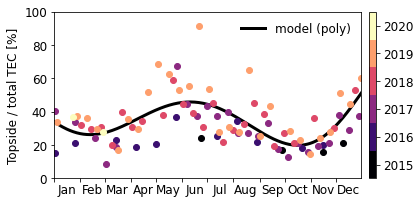

In [31]:
# prepare data
years = sorted(list(set([d.year for d in dates])))
num_year = len(years)
year0 = 2016

# plot
fig, ax = plt.subplots(figsize=[6, 3])

# plot - model fit
#ax.axhline(np.nanmedian(perc), c='k', ls='--', lw=3)
x = ptime.date_list2vector(ptime.get_date_range('20160101', '20161231'))[0]
top_perc_pred = ffit(np.linspace(1, 366, num=366))
ax.plot(x, top_perc_pred, c='k', ls='-', lw=3, label='model (poly)')

cmap = plt.get_cmap('magma', lut=num_year)
for i, year in enumerate(years):
    flag = np.array([d.year == year for d in dates], dtype=np.bool_)
    xs = [x.replace(year=year0) for x in np.array(dates)[flag]]
    ax.plot(xs, perc[flag], 'o', c=cmap(i))

# axis format
ax.set_ylabel('Topside / total TEC [%]')
ax.set_ylim(0, 100)
ax.set_xlim(dt.datetime(year0, 1, 1), dt.datetime(year0, 12, 31))
# centering labels beetween ticks (https://matplotlib.org/stable/gallery/ticks_and_spines/centered_ticklabels.html)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')
ax.legend(frameon=False)

# colorbar
cax = make_axes_locatable(ax).append_axes('right', 0.1, pad=0.1, axes_class=plt.Axes)
cbar = colorbar.ColorbarBase(cax, cmap=cmap, ticks=((np.arange(num_year) + 0.5) / num_year))
cbar.ax.set_yticklabels(years)

fig.tight_layout()
# output
out_fig = os.path.join(proj_dir, 'offset_comp/topTEC_perc.pdf')
print('save figure to file', out_fig)
#plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()